In [1]:
# This class tests whether the tensorflow and autograd versions give identical outputs for a simple least squared loss function

In [2]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.autograd.lma import LMA as LMAag
from sopt.optimizers.tensorflow import LMA as LMAtf

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
z_true = np.random.randn(3,10).astype('float32')

random_mat = np.random.randn(3,3)
random_symmetric_mat = random_mat + random_mat.T
evals, evecs = np.linalg.eig(random_symmetric_mat)
affine_transform = evecs

y_true = affine_transform @ z_true
y_true_flat = y_true.flatten()

In [15]:
def y_pred(z_flat):
    z_arr = np.reshape(z_flat, (3, -1))
    return (affine_transform @ z_arr).flatten()

def loss_fn(y):
    return 0.5 * np.sum((y - y_true_flat)**2)

In [16]:
z_guess = np.random.randn(30).astype('float32')

In [17]:
# Testing the autograd implementations

In [18]:
ag_lma1 = LMAag(z_guess, y_pred, loss_fn, squared_loss=True, damping_factor=1., cg_tol=1e-5)
ag_lma2 = LMAag(z_guess, y_pred, loss_fn, squared_loss=False, damping_factor=1., cg_tol=1e-5)

In [19]:
ag_losses1 = []
ag_losses2 = []
for i in range(5):
    out1 = ag_lma1.minimize()
    out2 = ag_lma2.minimize()
    print(i, loss_fn(y_pred(out1)), loss_fn(y_pred(out2)))
    ag_losses1.append(loss_fn(y_pred(out1)))
    ag_losses2.append(loss_fn(y_pred(out2)))

0 10.12627016594906 10.12627016594906
1 1.6202032265518493 1.6202032265518493
2 0.1533920214486955 0.1533920214486955
3 0.00801395050834 0.00801395050834
4 0.0002180435041061846 0.0002180435041061846


In [20]:
# Tensorflow test

In [40]:
tf.reset_default_graph()
var1 = tf.get_variable('var1', dtype=tf.float32, initializer=z_guess)
var2 = tf.get_variable('var2', dtype=tf.float32, initializer=z_guess)
var3 = tf.get_variable('var3', dtype=tf.float32, initializer=z_guess)

tf_y_true = tf.convert_to_tensor(y_true_flat, dtype='float32', name='y_true')
tf_affine_transform = tf.convert_to_tensor(affine_transform, dtype='float32', name='affine_transform')

def tf_y_pred(z):
    return tf.reshape(tf_affine_transform @ tf.reshape(z, [3, -1]), [-1])
def tf_loss(y_pred):
    return 0.5 * tf.reduce_sum((tf_y_true - y_pred)**2) - 500
def tf_hessian(y_pred):
    return 1.0

preds1 = tf_y_pred(var1)
preds2 = tf_y_pred(var2)
preds3 = tf_y_pred(var3)
loss_tensor1 = tf_loss(preds1)
loss_tensor2 = tf_loss(preds2)
loss_tensor3 = tf_loss(preds3)

tf_lma1 = LMAtf(var1, tf_y_pred, tf_loss, name='opt1', squared_loss=True, cg_tol=1e-5)
tf_lma2 = LMAtf(var2, tf_y_pred, tf_loss, name='opt2', squared_loss=False, cg_tol=1e-5)
tf_lma3 = LMAtf(var3, tf_y_pred, tf_loss, name='opt3', squared_loss=False, hessian_fn=tf_hessian, cg_tol=1e-5)


tf_lma1_min = tf_lma1.minimize()
tf_lma2_min = tf_lma2.minimize()
tf_lma3_min = tf_lma3.minimize()
session = tf.Session()
session.run(tf.global_variables_initializer())

W1205 09:34:35.334561 140456999921472 lma_new.py:143] The ftol, gtol, and xtol conditions are adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html.This is a test version, and there is no guarantee that these work as intended.
W1205 09:34:35.663875 140456999921472 lma_new.py:143] The ftol, gtol, and xtol conditions are adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html.This is a test version, and there is no guarantee that these work as intended.
W1205 09:34:36.206530 140456999921472 lma_new.py:143] The ftol, gtol, and xtol conditions are adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html.This is a test version, and there is no guarantee that these work as intended.


In [41]:
tf_losses1 = []
tf_losses2 = []
tf_losses3 = []
for i in range(5):
    session.run([tf_lma1_min, tf_lma2_min, tf_lma3_min])
    print(session.run(tf_lma1._damping_factor))
    lossval1, lossval2, lossval3 = session.run([loss_tensor1, loss_tensor2, loss_tensor3])
    print(i, lossval1, lossval2, lossval3)
    tf_losses1.append(lossval1)
    tf_losses2.append(lossval2)
    tf_losses3.append(lossval3)
    

0.6666667
0 -489.87372 -489.87372 -489.87372
0.44444448
1 -498.3798 -498.3798 -498.3798
0.29629633
2 -499.84662 -499.84662 -499.84662
0.1975309
3 -499.99197 -499.99197 -499.99197
0.13168727
4 -499.9998 -499.9998 -499.9998


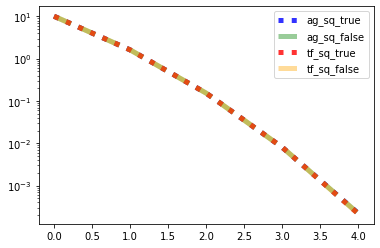

In [42]:
plt.plot(ag_losses1, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag_sq_true')
plt.plot(ag_losses2, color='green', ls='--', linewidth=5.0, alpha=0.4, label='ag_sq_false')
plt.plot(np.array(tf_losses1) + 500, color='red', ls=':', linewidth=5.0, alpha=0.8, label='tf_sq_true')
plt.plot(np.array(tf_losses2) + 500, color='orange', ls='--', linewidth=5.0, alpha=0.4, label='tf_sq_false')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [29]:
session.run(var1)

array([-1.693111  ,  0.6961818 ,  1.4490342 , -0.9481077 ,  1.8455472 ,
        0.9819226 ,  2.3330898 ,  1.3036275 ,  1.3316226 , -0.3771391 ,
       -0.93641376,  2.2393725 ,  0.5209918 ,  2.1554024 , -0.4919834 ,
       -2.2240825 ,  0.3248706 ,  1.3737745 , -0.750793  ,  0.4688263 ,
       -0.32746792, -0.5071511 , -0.2870059 ,  1.4028902 ,  0.45804977,
        1.675847  ,  1.2983289 ,  0.21939039, -0.2184372 ,  0.9751215 ],
      dtype=float32)

In [27]:
z_true

array([[-1.6931113 ,  0.69618213,  1.4490342 , -0.94810796,  1.8455478 ,
         0.98192334,  2.33309   ,  1.3036282 ,  1.3316232 , -0.3771387 ],
       [-0.93641347,  2.2393723 ,  0.5209916 ,  2.1554017 , -0.49198323,
        -2.2240825 ,  0.32486978,  1.3737755 , -0.75079286,  0.46882647],
       [-0.3274678 , -0.50715107, -0.28700578,  1.4028906 ,  0.45805043,
         1.6758475 ,  1.2983289 ,  0.2193911 , -0.21843696,  0.97512156]],
      dtype=float32)